# Description:
In this notebook the application of frequency windows via NuRadioMC is explored and toyed around with.

# Import modules:

In [2]:
import numpy as np
import scipy as sc
import scipy.fft as scfft
import matplotlib.pyplot as plt
import uproot
import datetime as dt
from datetime import datetime
import csv
#from datetime import datetime

In [3]:
%%capture out
%run /mnt/c/Users/Jethro/Desktop/Master\ Thesis/Functions.ipynb
%run /mnt/c/Users/Jethro/Desktop/RNO-G/GalaxyFunctions.ipynb
#%matplotlib widget

# Import data

In [4]:
import NuRadioReco.modules.channelBandPassFilter
from NuRadioReco.detector import detector
from NuRadioReco.utilities import units
from NuRadioReco.framework import event,station

In [23]:
#channelBandPassFilter = NuRadioReco.modules.channelBandPassFilter.channelBandPassFilter()
#channelBandPassFilter.run(evt, station, det,passband=[1 * units.MHz, 700 * units.MHz], filter_type="butter", order=10)
#Event(self, run_number, event_id)
det = detector.Detector(json_filename = "/mnt/c/Users/Jethro/AppData/Roaming/Microsoft/Windows/Start Menu/Programs/Python 3.8/NuRadioMC/NuRadioReco/detector/RNO_G/RNO_season_2021.json")
det.update(datetime(2022, 10, 1)) #date in example
Event=event.Event(532,206)
Station=station.Station(22)

channelBandPassFilter = NuRadioReco.modules.channelBandPassFilter.channelBandPassFilter()
channelBandPassFilter.run(Event, Station, det,passband=[1 * units.MHz, 700 * units.MHz], filter_type="butter", order=10)

NuRadioReco library proved more difficult to provide required filtering than just using scipy.signal <br>
Example of a problematic timetrace which needs filtering:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
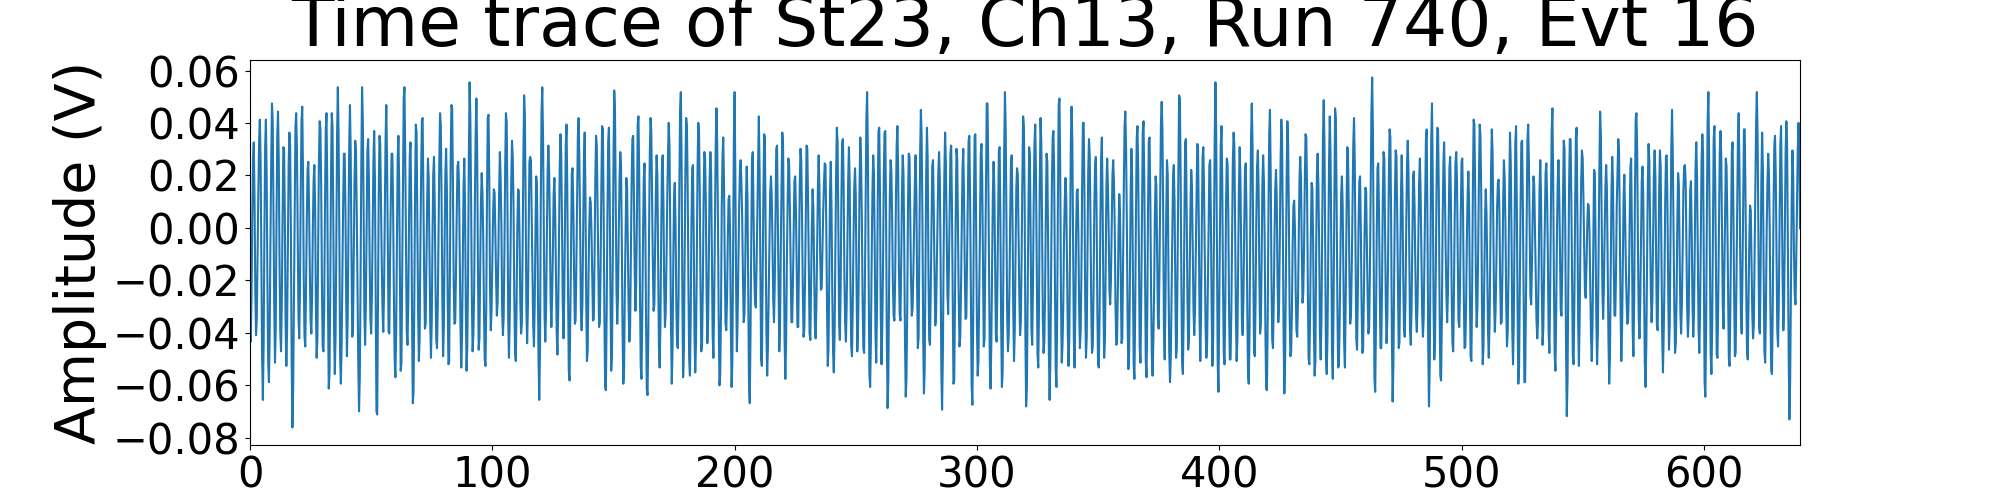

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
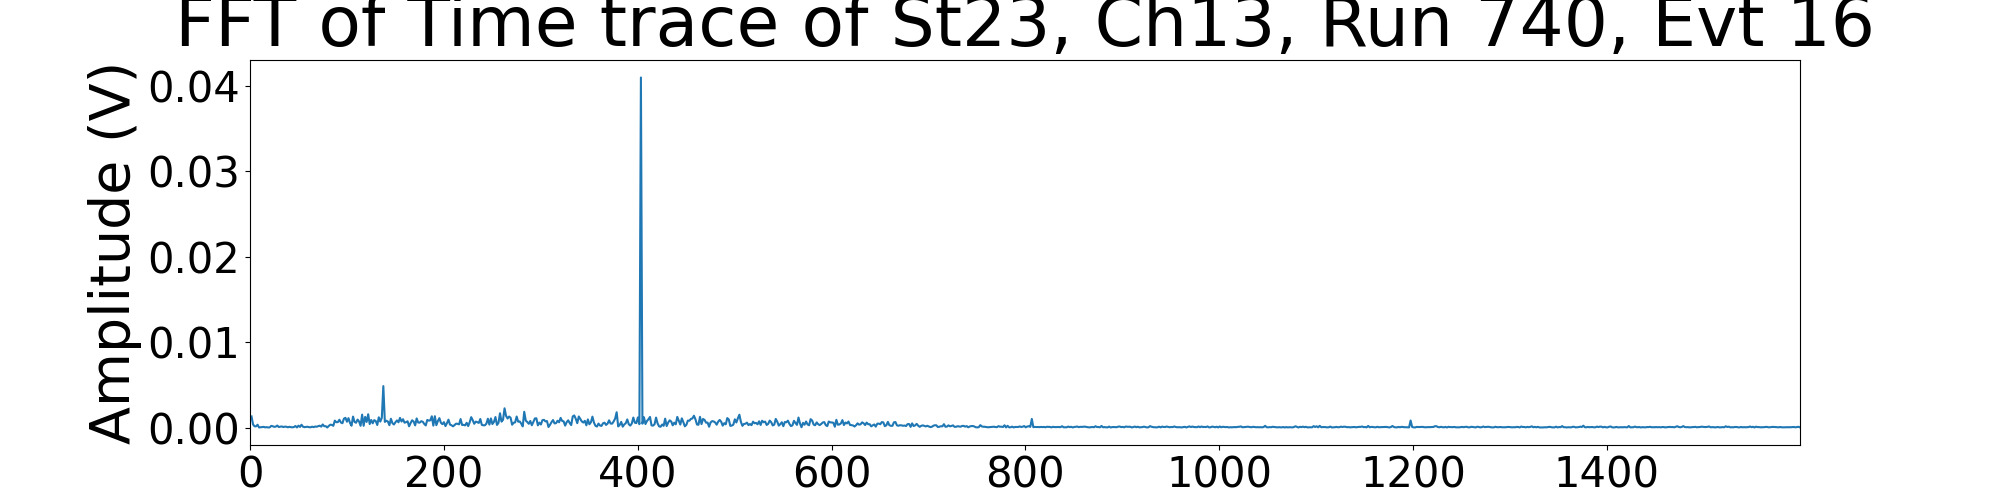

In [105]:
TimeTrace(23,13,740,16,Amplitude="V")
TimeTraceFFT(23,13,740,16,Amplitude="V")

Use the Butterworth window as this is a maximally flat window.

In [5]:
sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
TimeStep=1/sampling_rate #Time between two samples
SamplingTimes=np.arange(0,2048*TimeStep,TimeStep)
freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))
freq=np.fft.fftshift(freq)

(0.0, 1000000000.0)

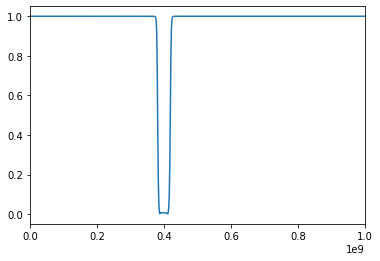

In [71]:
from scipy import signal
b,a=signal.butter(10, (2*np.pi*380*10**6,2*np.pi*420*10**6), btype='bandstop', analog=True, output='ba', fs=None)
w, h = signal.freqs(b, a,worN=2*np.pi*freq)
plt.plot(freq,np.abs(h))
plt.xlim(0,10**9)
plt.show()

The narrowest I seem to be able to get the window is approx 40MHz width.
Implement the Buttersworth filter:

In [51]:
def TimeTraceFFTFiltered(StNr,ChNr,Run,EvNr,CritFreq):
    from scipy import signal
    path=Path(StNr,Run)
    if os.path.isfile(path+"/combined.root") and os.path.isfile(path+"/daqstatus.root"):
        
        CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
        RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
        EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
        TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')
    
    else:
        return
    
    if not EvNr in EventNrs:
        print("There is no event with this number")
        return
        
    
    EvIndex=np.where(EventNrs==EvNr)[0][0]
    sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
    TimeStep=1/sampling_rate #Time between two samples
    SamplingTimes=np.arange(0,len(RadiantData[0][0])*TimeStep,TimeStep)
    freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))
    freq=np.fft.fftshift(freq)
    
    b,a=signal.butter(10, (2*np.pi*380*10**6,2*np.pi*420*10**6), btype='bandstop', analog=True, output='ba', fs=None)
    w, h = signal.freqs(b, a,worN=2*np.pi*freq)
    
    
    plt.figure(figsize=(20,5))
    

    FFT=scfft.fft(ADCtoVoltage(RadiantData[EvIndex][ChNr]))
    FFT=np.fft.fftshift(FFT)
    FFT=np.array([FFT[i]*np.abs(h)[i] for i in range(len(freq))])
    plt.plot((freq*(10**-6))[int(len(freq)/2)+1:len(freq)],(2/len(SamplingTimes))*np.abs(FFT)[int(len(FFT)/2)+1:len(FFT)],'-', label="Channel " + str(ChNr))
    plt.ylabel("Amplitude (V)",fontsize=40)#20)

    #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
    plt.title("FFT of Time trace of St" + str(StNr) + ", Ch" + str(ChNr) + ", Run " + str(Run) + ", Evt " + str(EvNr),fontsize=50)#25)
    #plt.ylim(-50,50)
    plt.xlim(0,np.max(freq*(10**-6)))
    plt.xlabel("Frequency (MHz)",fontsize=40)#20)

    plt.xticks(fontsize=30)#15)
    plt.yticks(fontsize=30)#15)
    #plt.legend()
    plt.show()

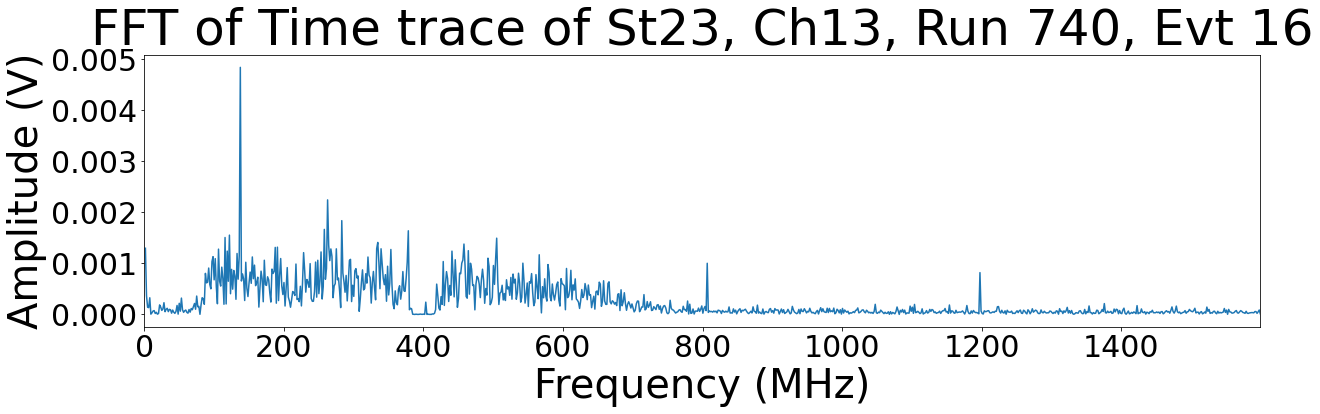

In [52]:
TimeTraceFFTFiltered(23,13,740,16,(399*10^6,401*10^6))

Peak at 400MHz succesfully filtered out, however, now there remains a large emptiness in the FFT spectrum while the peak was much more narrow. <br>
Inspect how narrow each of these peaks is:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
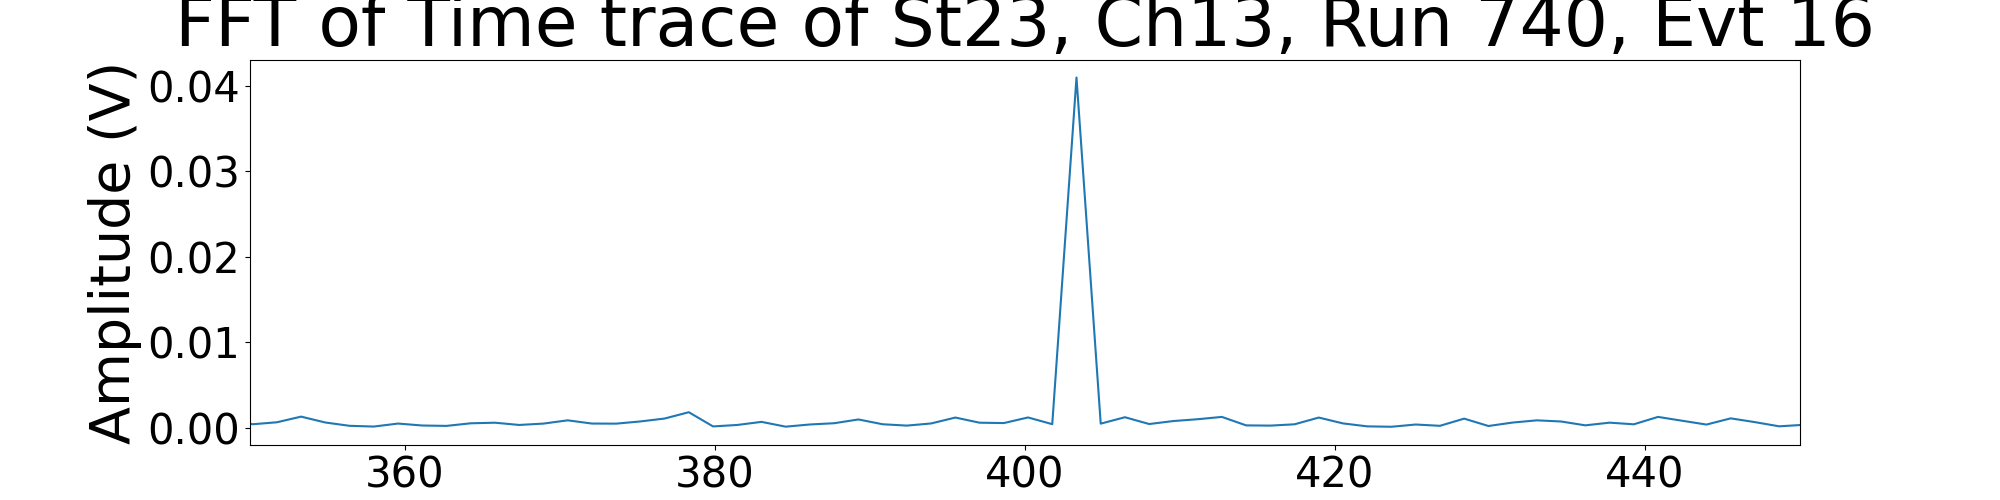

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
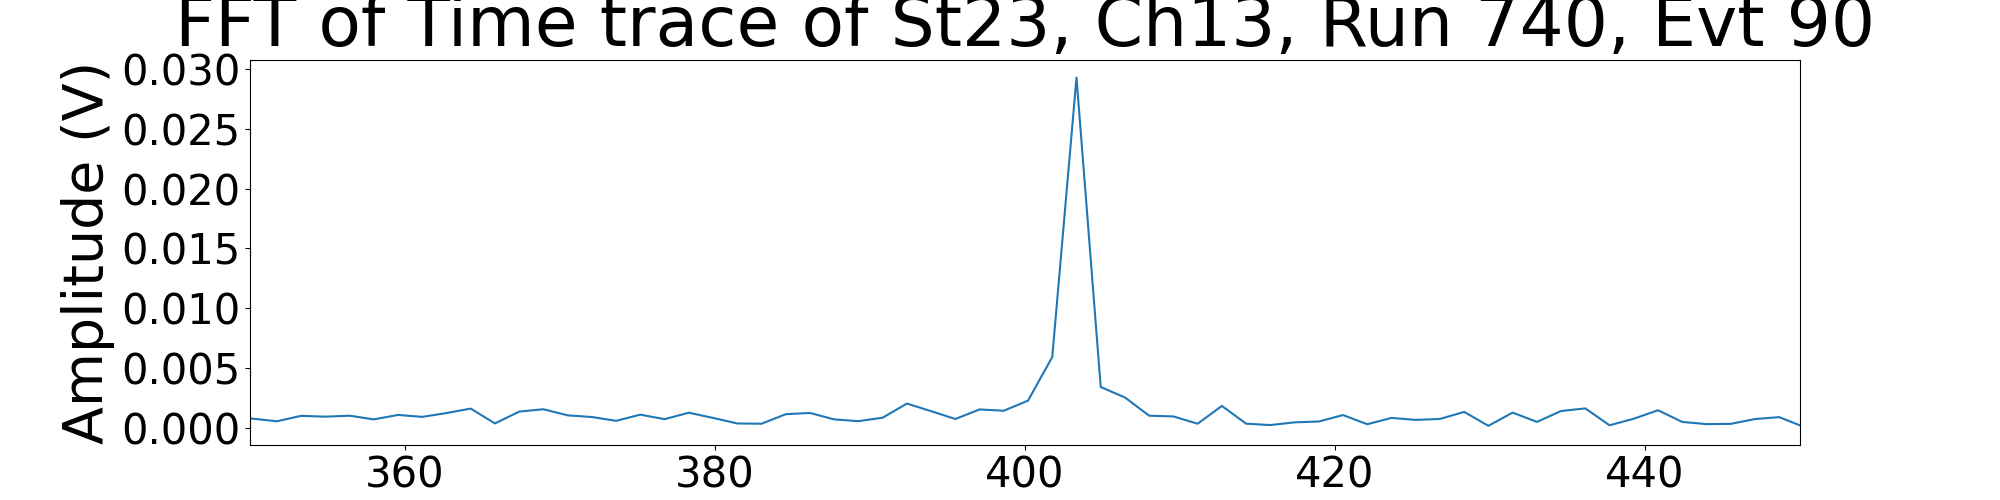

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
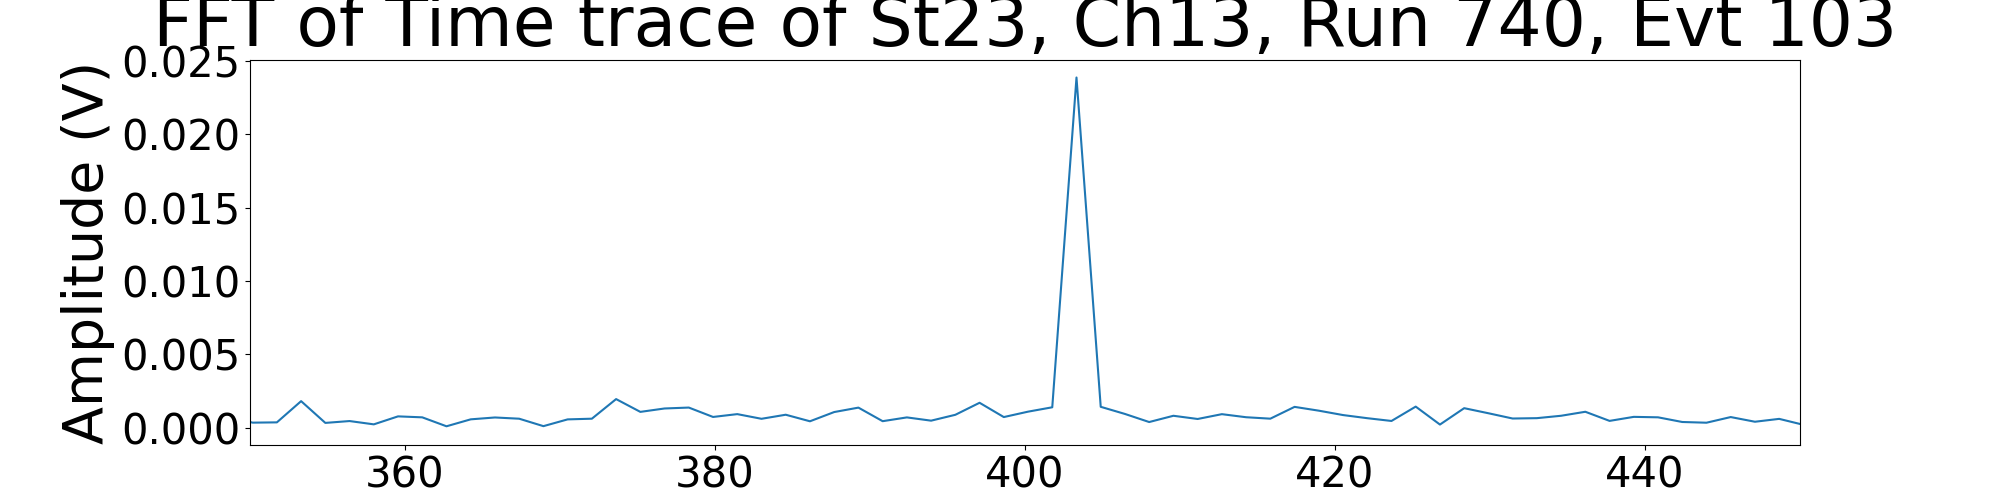

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
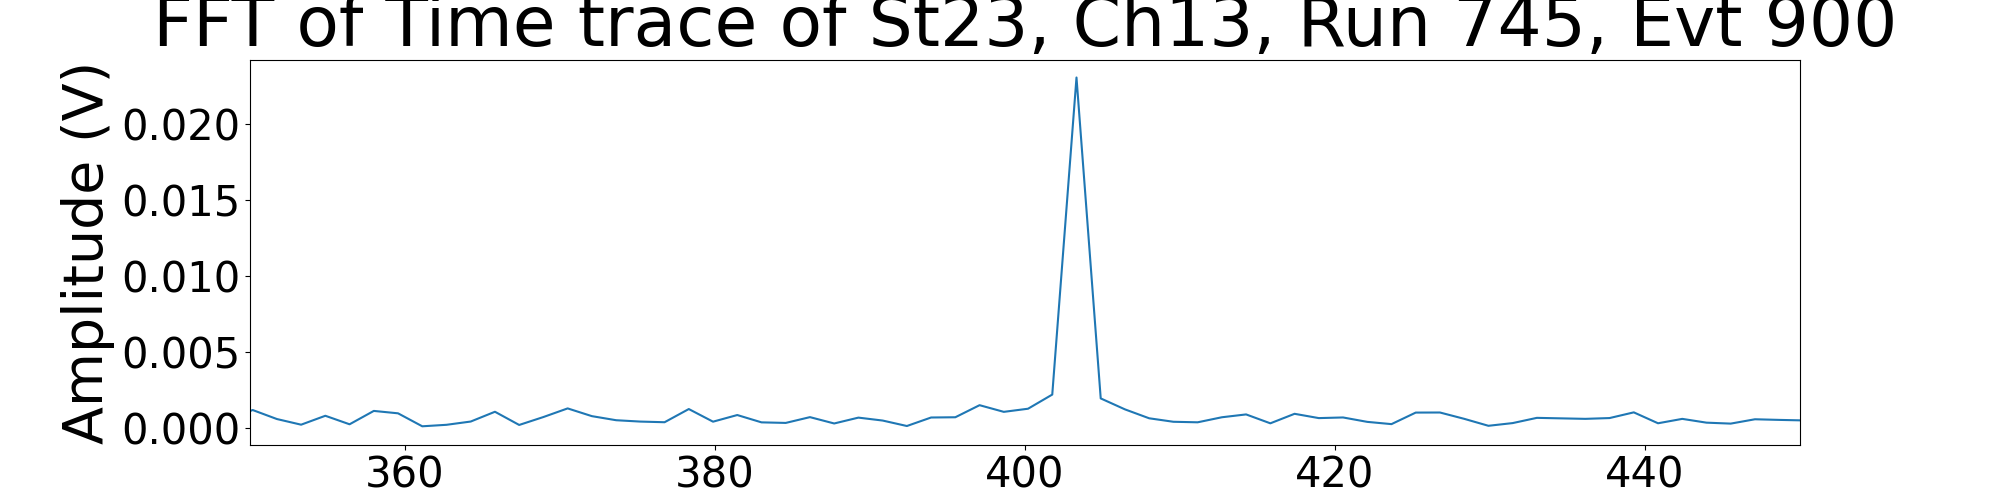

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
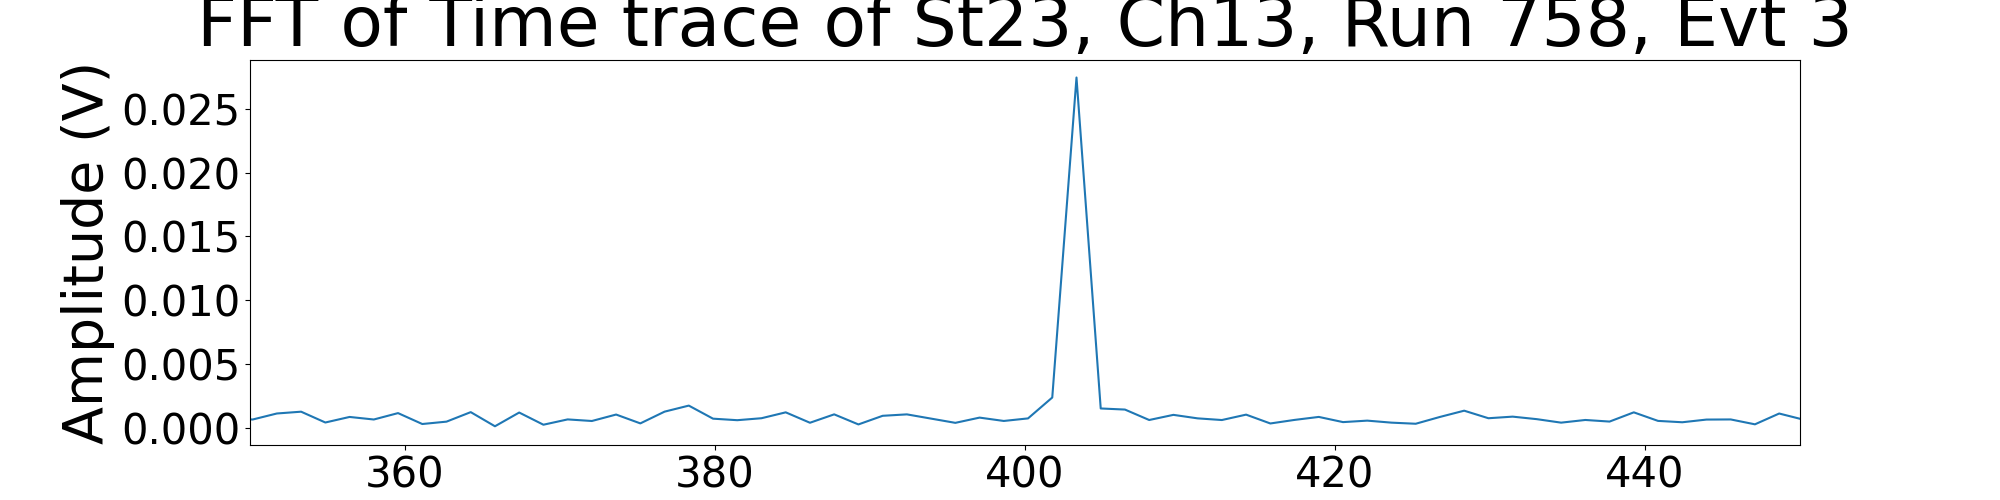

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
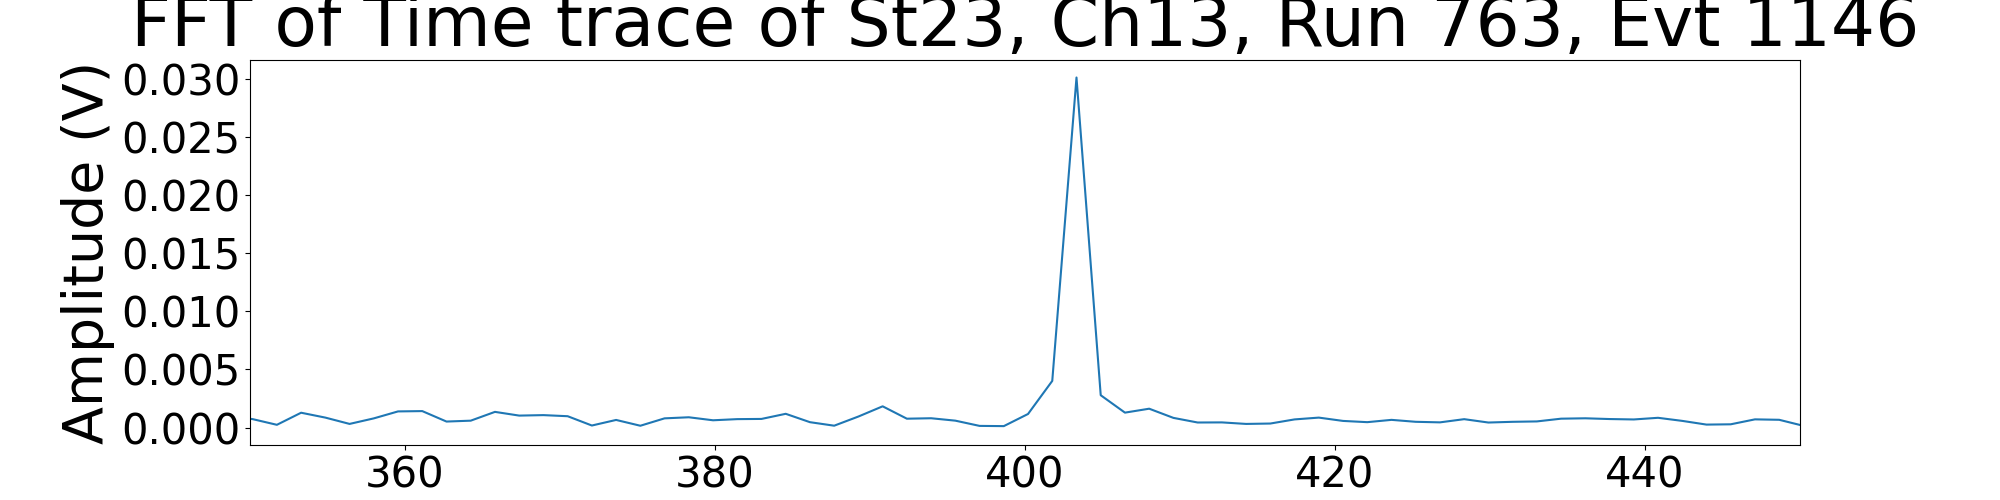

In [100]:
TimeTraceFFT(23,13,740,16,Amplitude="V")
TimeTraceFFT(23,13,740,90,Amplitude="V")
TimeTraceFFT(23,13,740,103,Amplitude="V")
TimeTraceFFT(23,13,745,900,Amplitude="V")
TimeTraceFFT(23,13,758,3,Amplitude="V")
TimeTraceFFT(23,13,763,1146,Amplitude="V")

Most peaks don't seem to be much broader than one sample. => instead of applying a window just set this sample to zero instead to preserve the waveform better?

In [85]:
def TimeTraceFFTFilteredAlt(StNr,ChNr,Run,EvNr,CritFreq):
    from scipy import signal
    path=Path(StNr,Run)
    if os.path.isfile(path+"/combined.root") and os.path.isfile(path+"/daqstatus.root"):
        
        CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
        RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
        EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
        TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')
    
    else:
        return
    
    if not EvNr in EventNrs:
        print("There is no event with this number")
        return
        
    
    EvIndex=np.where(EventNrs==EvNr)[0][0]
    sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
    TimeStep=1/sampling_rate #Time between two samples
    SamplingTimes=np.arange(0,len(RadiantData[0][0])*TimeStep,TimeStep)
    freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))
    freq=np.fft.fftshift(freq)
    
    
    plt.figure(figsize=(20,5))
    

    FFT=scfft.fft(ADCtoVoltage(RadiantData[EvIndex][ChNr]))
    FFT=np.fft.fftshift(FFT)
    FFT=[FFT[i] if not (400*10**6 < freq[i] < 410*10**6 or 130*10**6 < freq[i] < 140*10**6) else 0 for i in range(len(FFT)) ]
    plt.plot((freq*(10**-6))[int(len(freq)/2)+1:len(freq)],(2/len(SamplingTimes))*np.abs(FFT)[int(len(FFT)/2)+1:len(FFT)],'-', label="Channel " + str(ChNr))
    plt.ylabel("Amplitude (V)",fontsize=40)#20)

    #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
    plt.title("FFT of Time trace of St" + str(StNr) + ", Ch" + str(ChNr) + ", Run " + str(Run) + ", Evt " + str(EvNr),fontsize=50)#25)
    #plt.ylim(-50,50)
    plt.xlim(0,np.max(freq*(10**-6)))
    plt.xlabel("Frequency (MHz)",fontsize=40)#20)

    plt.xticks(fontsize=30)#15)
    plt.yticks(fontsize=30)#15)
    #plt.legend()
    plt.show()
    
    RetrievedWave=scfft.ifft(FFT)
    
    plt.figure(figsize=(20,5))
    
    plt.plot(SamplingTimes*(10**9),np.abs(RetrievedWave),'-', label="Channel " + str(ChNr))
    plt.ylabel("Amplitude (V)",fontsize=40)#20)
       
    #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
    plt.title("IFFT Time trace of St" + str(StNr) + ", Ch" + str(ChNr) + ", Run " + str(Run) + ", Evt " + str(EvNr),fontsize=50)#25)
    #plt.ylim(-50,50)
    plt.xlim(0,np.max(SamplingTimes*(10**9)))
    plt.xlabel("Time (ns)",fontsize=40)#20)

    plt.xticks(fontsize=30)#15)
    plt.yticks(fontsize=30)#15)
    #plt.legend()
    plt.show()

    

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
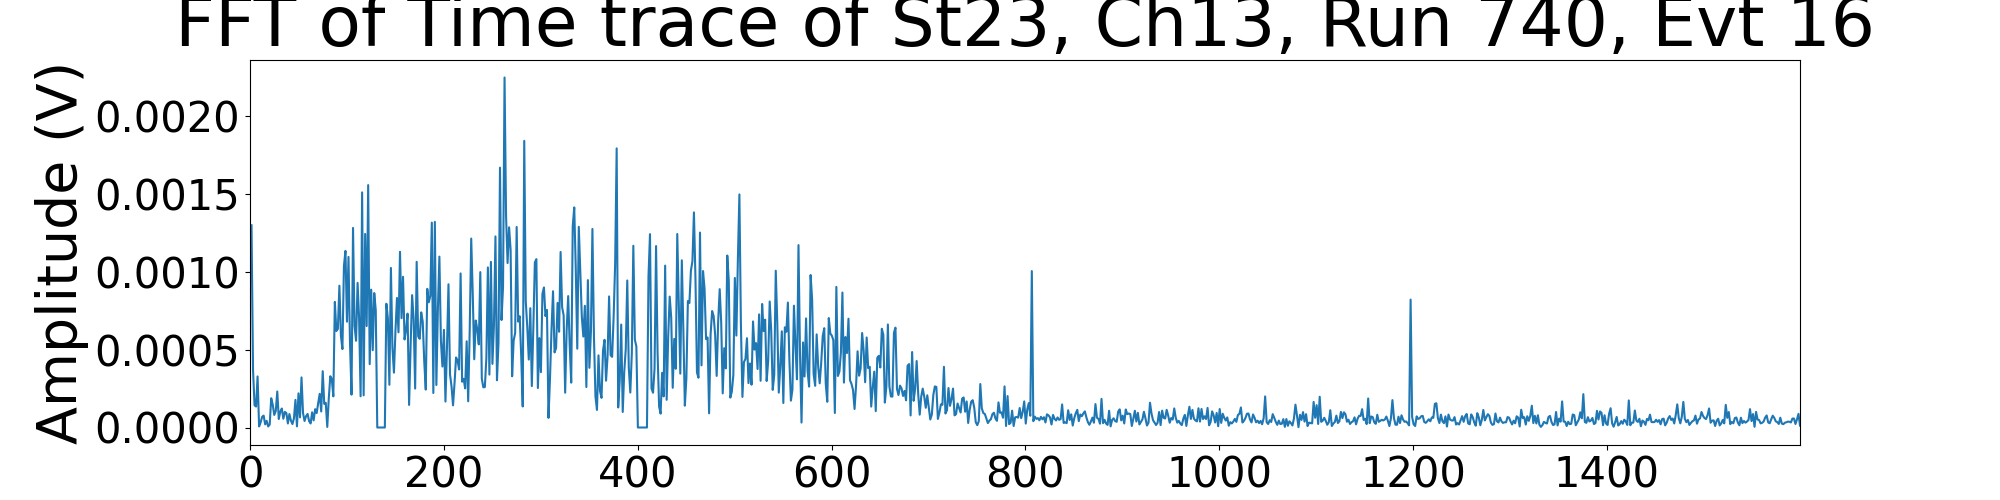

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
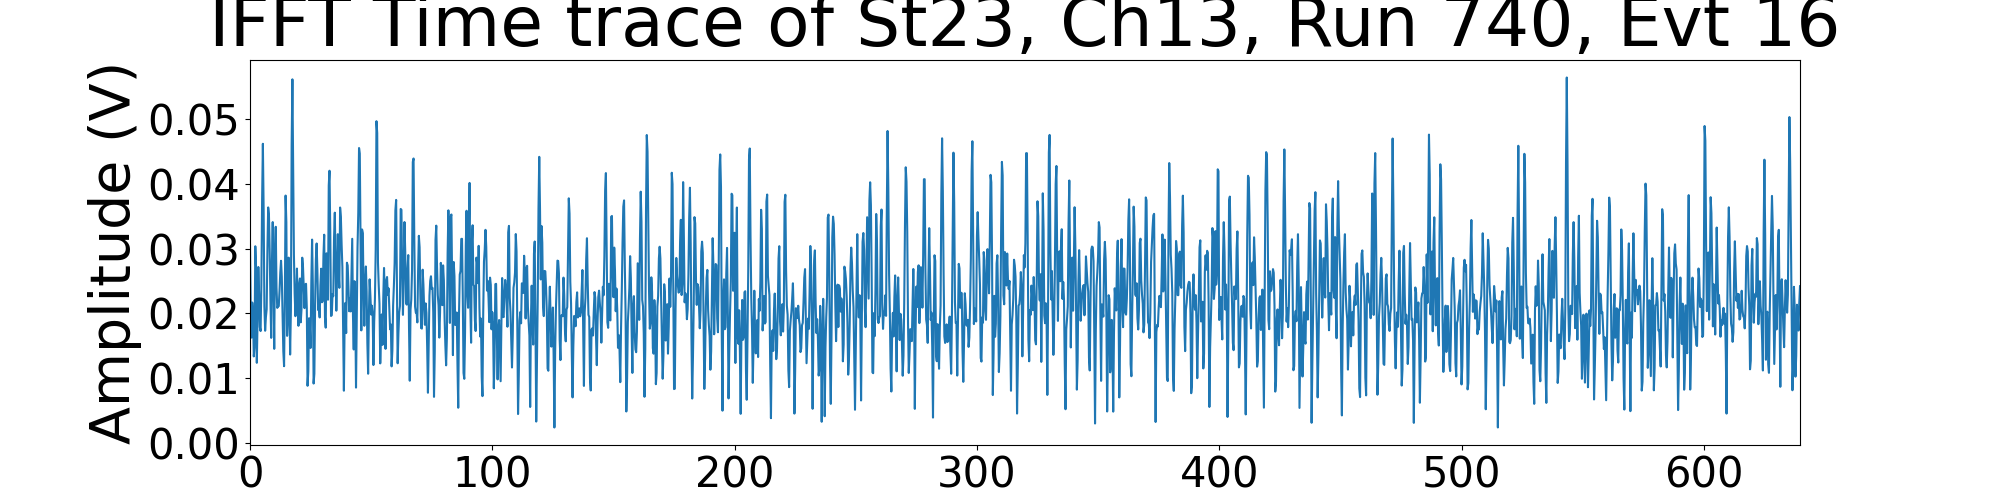

In [86]:
TimeTraceFFTFilteredAlt(23,13,740,16,(399*10^6,401*10^6))

Compare to a "healthy" timetrace:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
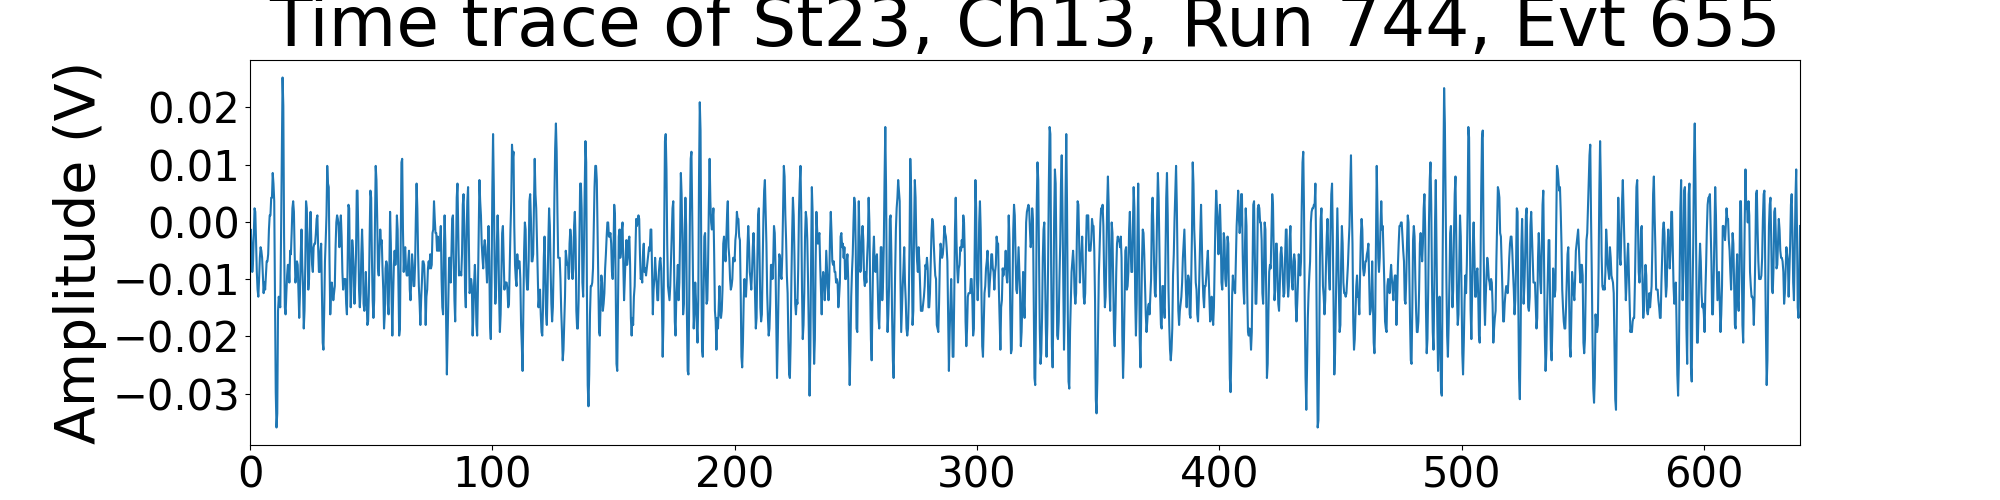

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
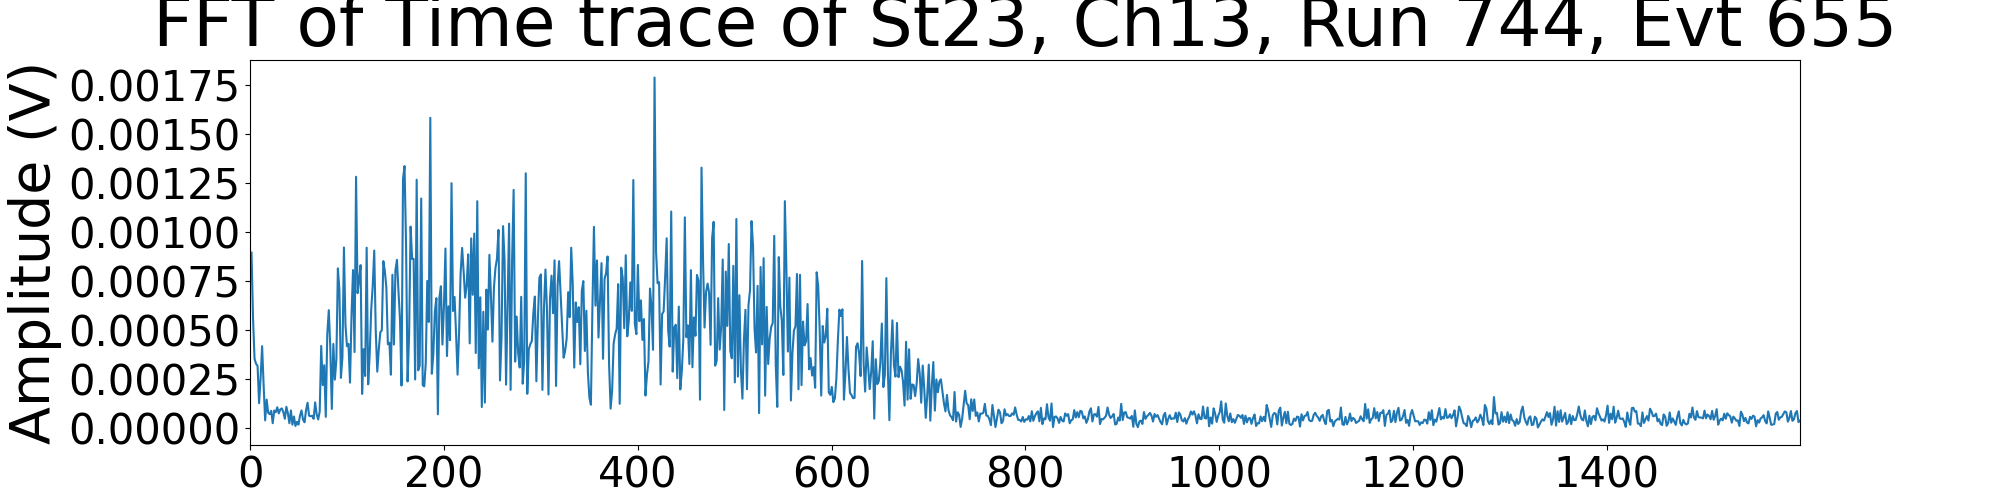

In [143]:
TimeTrace(23,13,744,655,Amplitude="V")
TimeTraceFFT(23,13,744,655,Amplitude="V")

Still some residual spikes in the >800MHz area and some higher spikes in the main area, which causes the timetrace to have a larger VRMS in general.

Try with the Notch filter:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
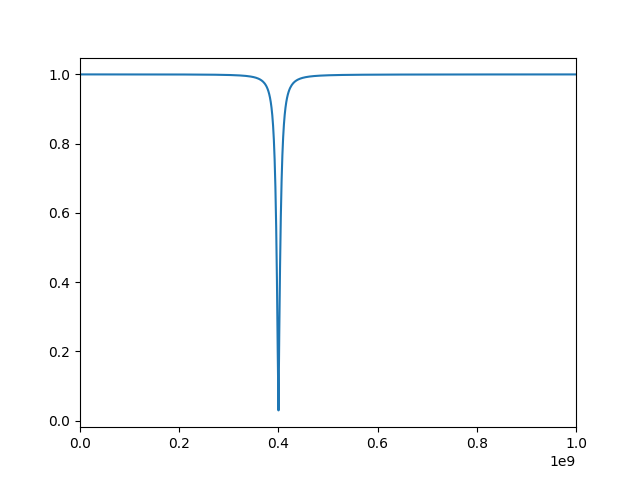

In [30]:
from scipy import signal
#b,a=signal.butter(10, (2*np.pi*380*10**6,2*np.pi*420*10**6), btype='bandstop', analog=True, output='ba', fs=None)
b,a=signal.iirnotch(400*10**6, 30, fs=sampling_rate)
w, h = signal.freqs(b, a,worN=2*np.pi*freq)
freqa, h = signal.freqz(b, a, worN=2*np.pi*freq,fs=2*np.pi*sampling_rate)
plt.figure()
plt.plot(freq,np.abs(h))
plt.xlim(0,10**9)
#plt.xlim(3*10**8,5*10**8)
plt.show()

In [102]:
def TimeTraceFFTNotchFiltered(StNr,ChNr,Run,EvNr,CritFreqs):
    from scipy import signal
    path=Path(StNr,Run)
    if os.path.isfile(path+"/combined.root") and os.path.isfile(path+"/daqstatus.root"):
        
        CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
        RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
        EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
        TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')
    
    else:
        return
    
    if not EvNr in EventNrs:
        print("There is no event with this number")
        return
        
    
    EvIndex=np.where(EventNrs==EvNr)[0][0]
    sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
    TimeStep=1/sampling_rate #Time between two samples
    SamplingTimes=np.arange(0,len(RadiantData[0][0])*TimeStep,TimeStep)
    freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))
    freq=np.fft.fftshift(freq)
    
    TotalFilter=NotchFilters(CritFreqs,30,freq,sampling_rate)
    
    plt.figure(figsize=(20,5))
    

    FFT=scfft.fft(ADCtoVoltage(RadiantData[EvIndex][ChNr]))
    FFT=np.fft.fftshift(FFT)
    FFT=np.array([FFT[i]*TotalFilter[i] for i in range(len(freq))])
    plt.plot((freq*(10**-6))[int(len(freq)/2)+1:len(freq)],(2/len(SamplingTimes))*np.abs(FFT)[int(len(FFT)/2)+1:len(FFT)],'-', label="Channel " + str(ChNr))
    plt.ylabel("Amplitude (V)",fontsize=40)#20)

    #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
    plt.title("FFT of Time trace of St" + str(StNr) + ", Ch" + str(ChNr) + ", Run " + str(Run) + ", Evt " + str(EvNr),fontsize=50)#25)
    #plt.ylim(-50,50)
    plt.xlim(0,np.max(freq*(10**-6)))
    plt.xlabel("Frequency (MHz)",fontsize=40)#20)

    plt.xticks(fontsize=30)#15)
    plt.yticks(fontsize=30)#15)
    #plt.legend()
    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
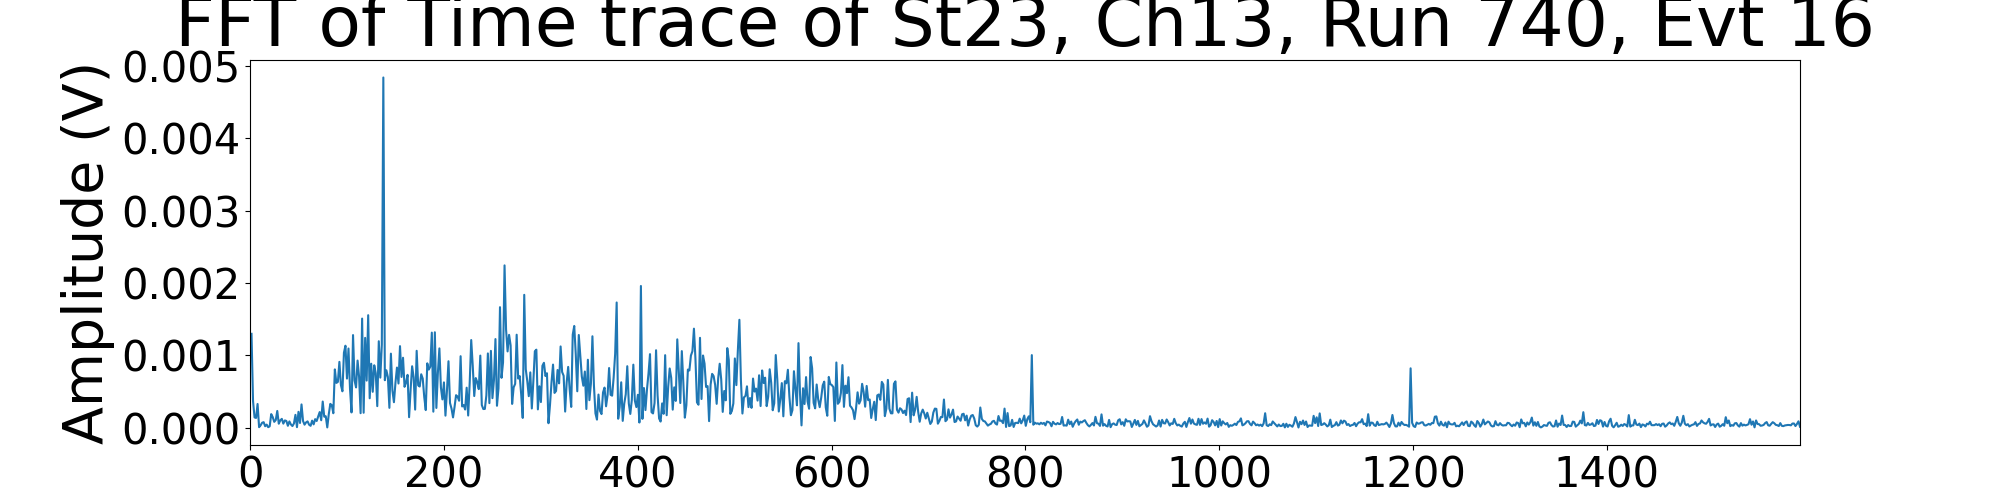

In [103]:
TimeTraceFFTNotchFiltered(23,13,740,16,[403*10**6],Amplitude="V")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
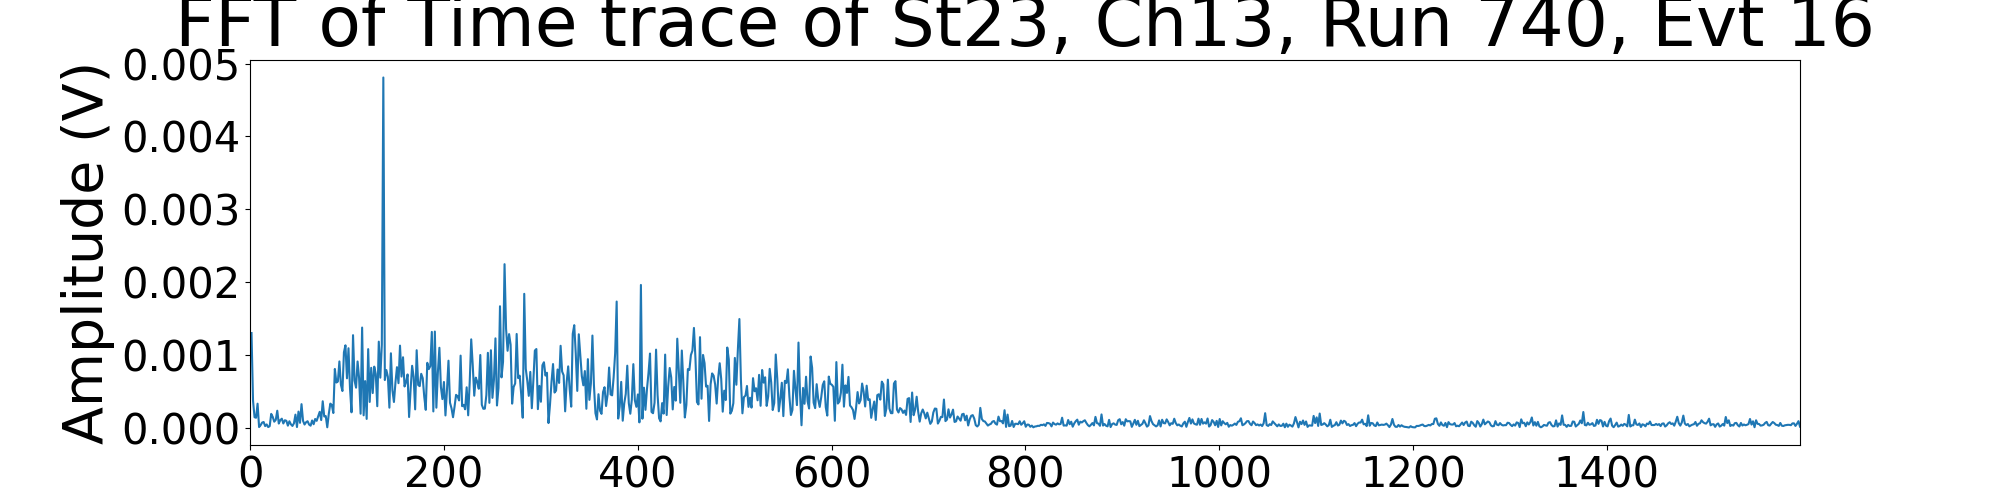

In [105]:
TimeTraceFFTNotchFiltered(23,13,740,16,[403*10**6,120*10**6,807*10**6,1197*10**6],Amplitude="V")

For the other problematic cases:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
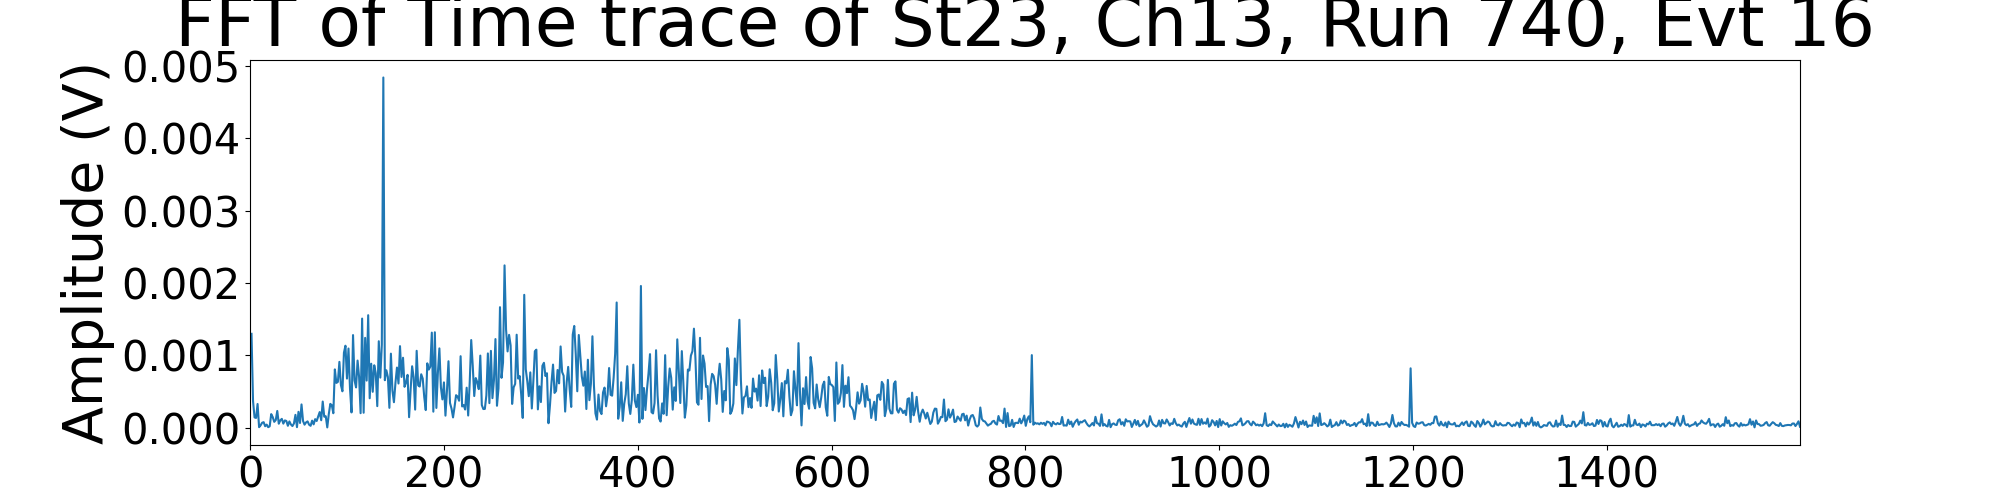

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
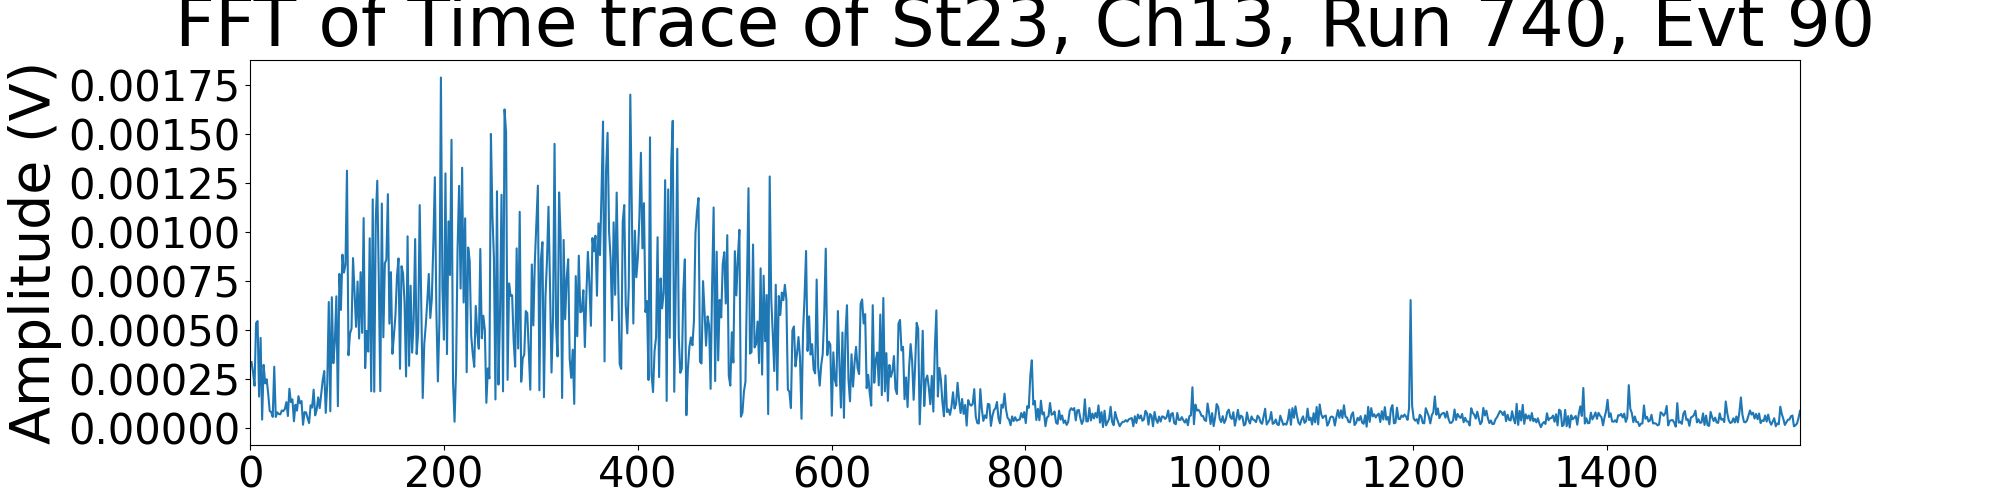

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
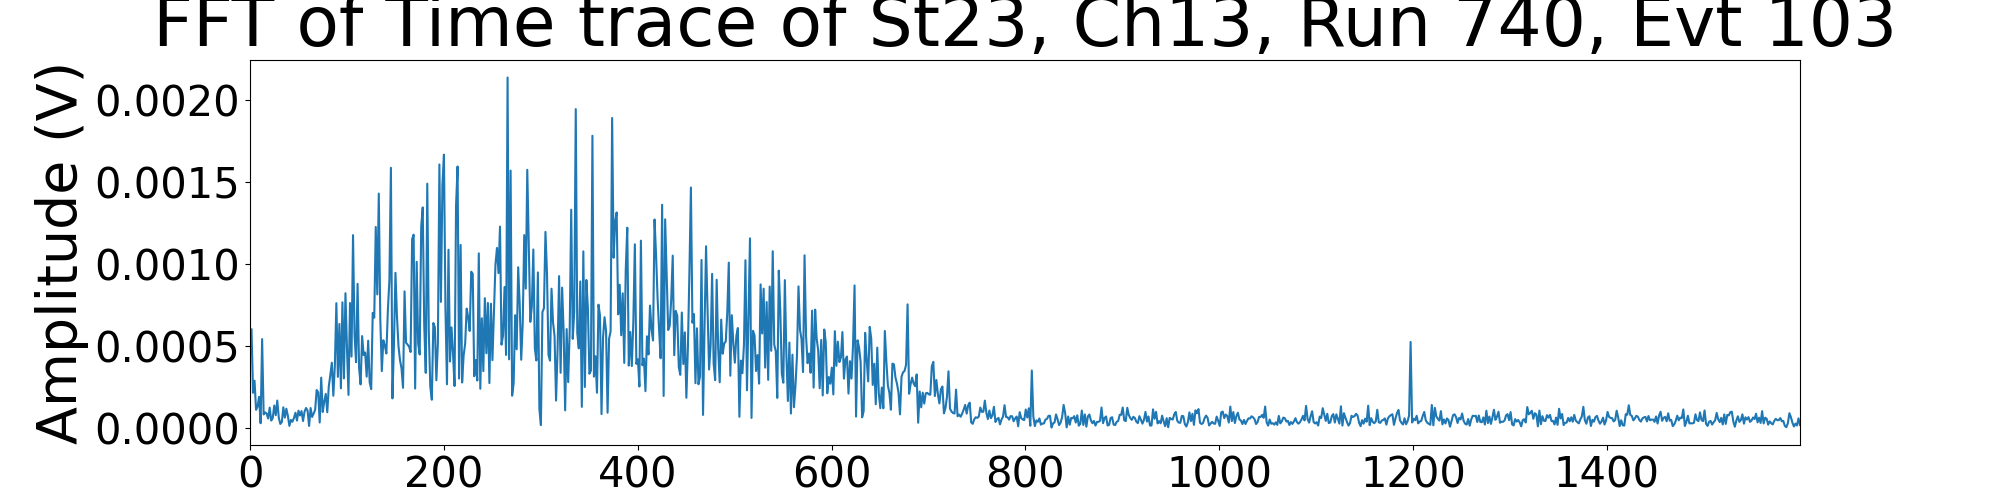

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
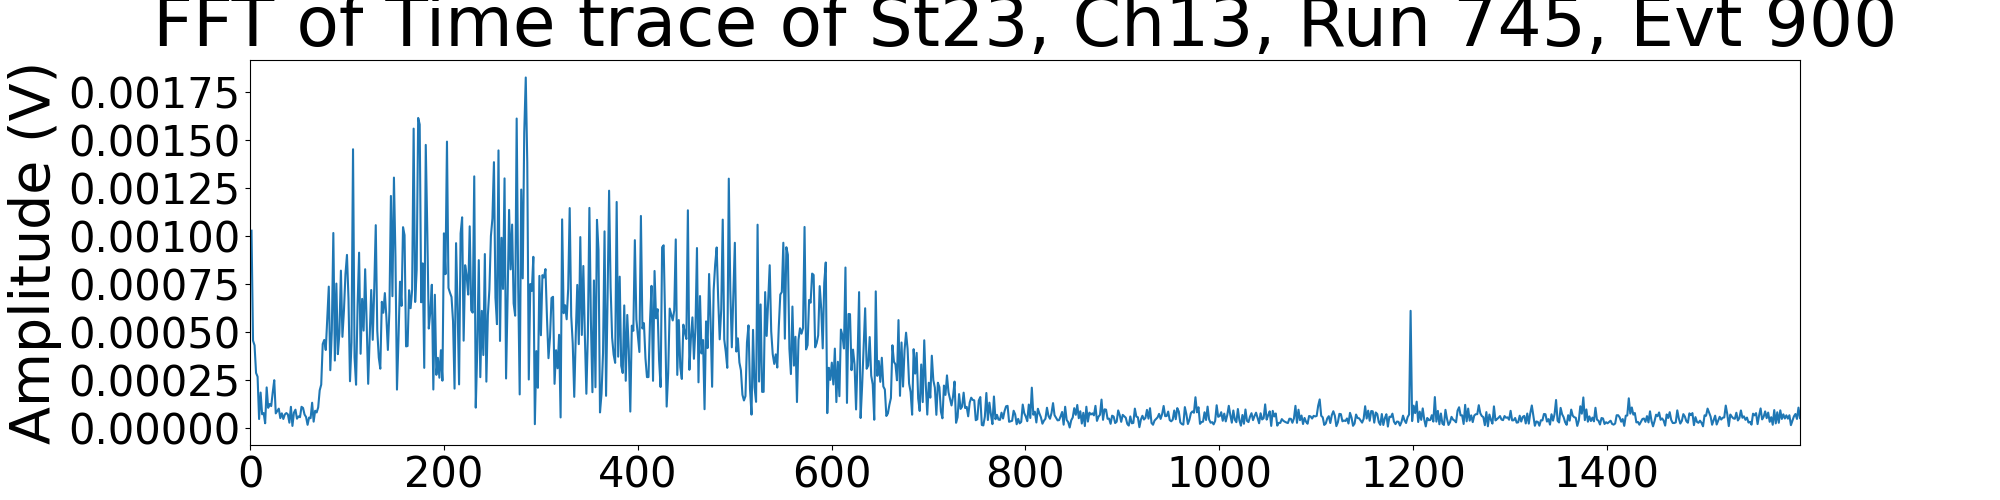

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
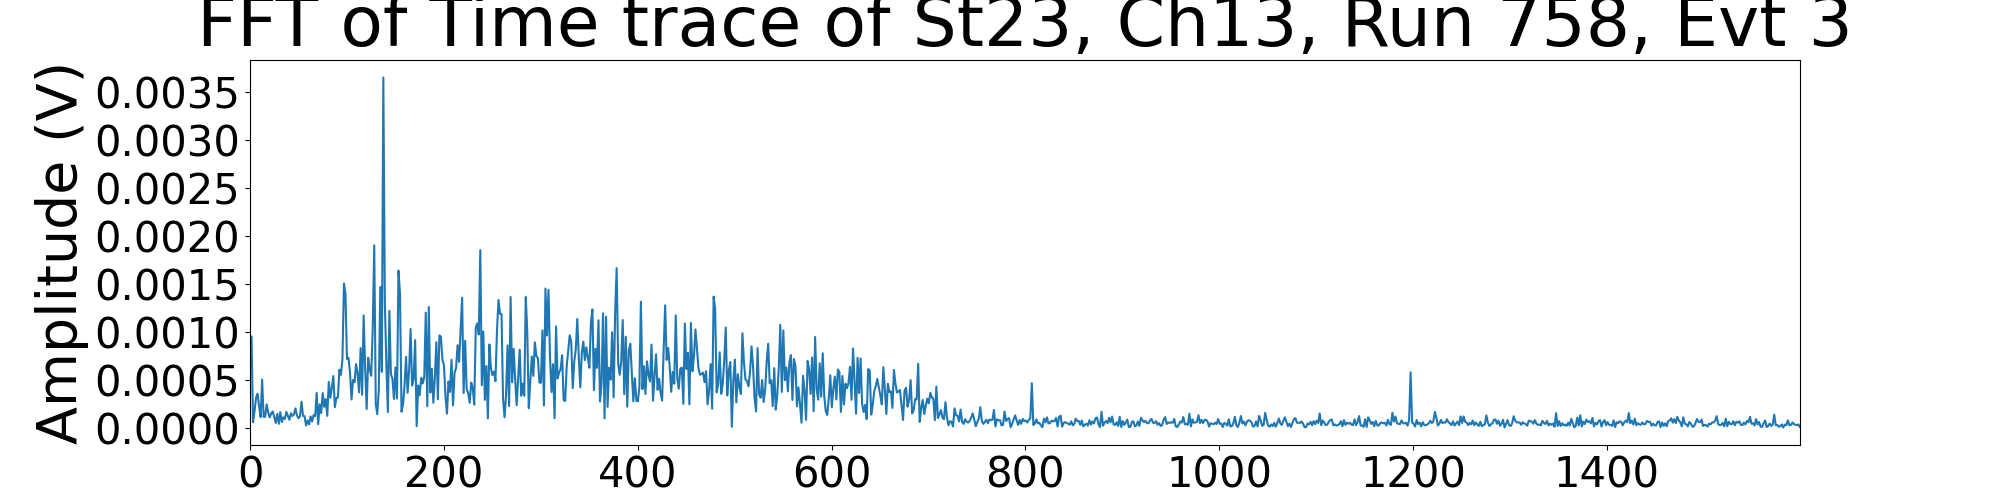

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
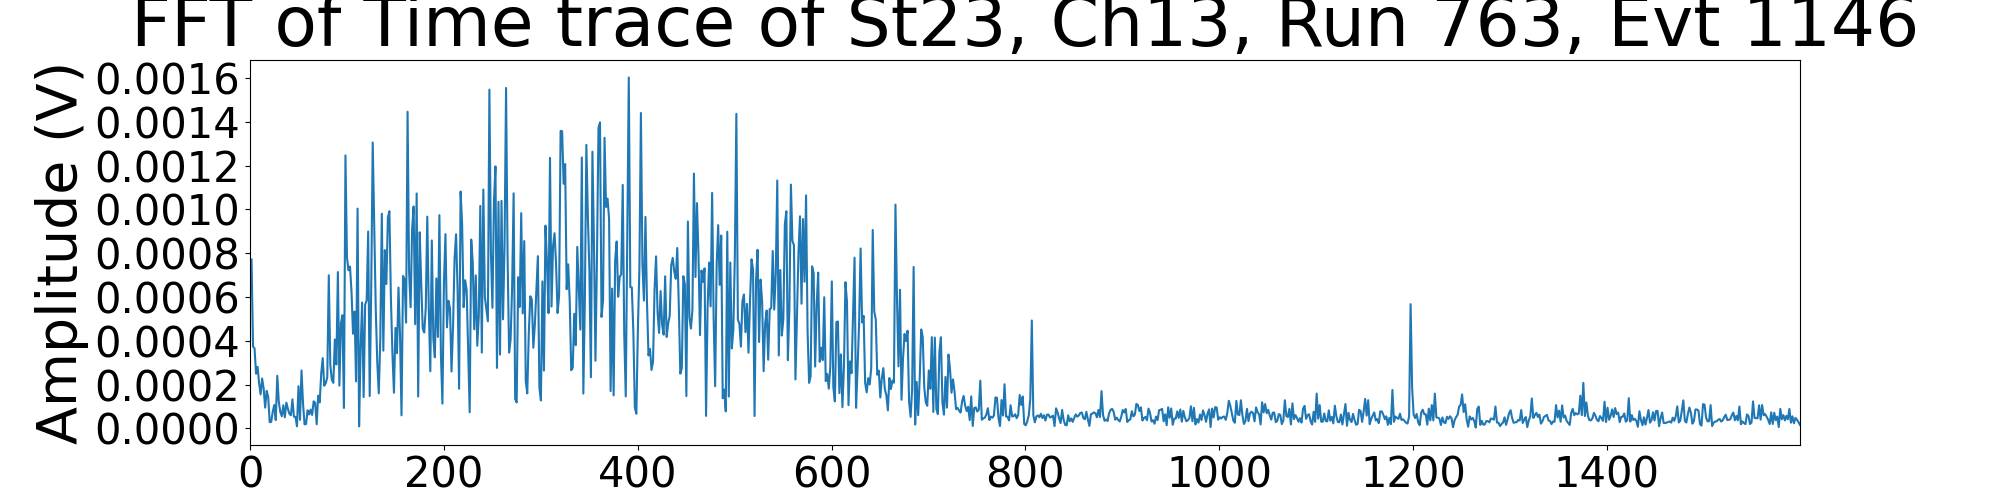

In [48]:
TimeTraceFFTNotchFiltered(23,13,740,16,403*10**6)
TimeTraceFFTNotchFiltered(23,13,740,90,403*10**6)
TimeTraceFFTNotchFiltered(23,13,740,103,403*10**6)
TimeTraceFFTNotchFiltered(23,13,745,900,403*10**6)
TimeTraceFFTNotchFiltered(23,13,758,3,403*10**6)
TimeTraceFFTNotchFiltered(23,13,763,1146,403*10**6)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
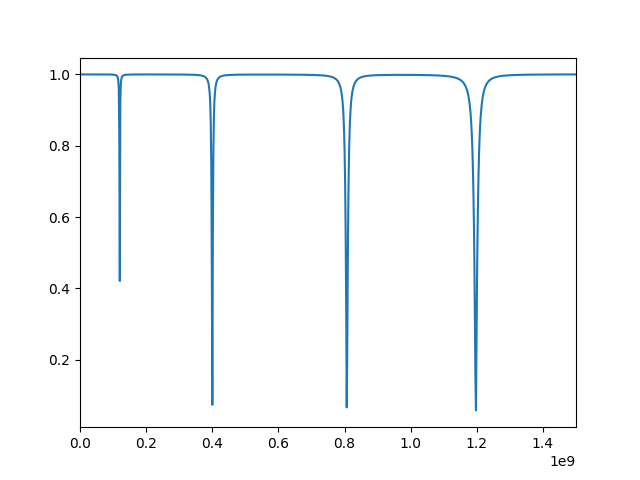

[0.9999999965762231 0.9999999965762231 0.9999999691843079 ...
 0.9999999143914082 0.9999999691843079 0.9999999965762231]


In [95]:
print(NotchFilters([403*10**6,120*10**6,807*10**6,1197*10**6],75,freq,sampling_rate))

In [8]:
T1=np.empty((1,5),dtype=object)
print(T1.shape)
T2=np.array([[1,2,3,4,5]])
print(T2.shape)
T3=np.array([[6,7,8,9,10]])
T4=np.array([[11,12,13,14,15]])
T=np.concatenate((T1,T2,T3,T4),axis=0)
T=np.delete(T,0,0)
print(T)
print(np.prod(T,axis=0))
print(np.multiply(T2,T3))

(1, 5)
(1, 5)
[[1 2 3 4 5]
 [6 7 8 9 10]
 [11 12 13 14 15]]
[66 168 312 504 750]
[[ 6 14 24 36 50]]


Galactic noise is dominant up to 110MHz (Lily msc) <br>
=> investigate a lowpass butterworth filter to keep only galactic noise dominated waveforms

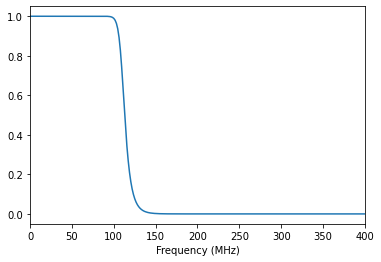

In [11]:
from scipy import signal
#b,a=signal.butter(10, (2*np.pi*380*10**6,2*np.pi*420*10**6), btype='bandstop', analog=True, output='ba', fs=None)
b,a=signal.butter(20, 2*np.pi*110*10**6, btype='low', analog=True, output='ba', fs=None)
w, h = signal.freqs(b, a,worN=2*np.pi*freq)
plt.figure()
plt.plot(freq/(10**6),np.abs(h))
plt.xlim(0,400)
plt.xlabel("Frequency (MHz)")
plt.show()

In [6]:
def TimeTraceFFTLowpassFiltered(StNr,ChNr,Run,EvNr,CritFreq):
    from scipy import signal
    path=Path(StNr,Run)
    if os.path.isfile(path+"/combined.root") and os.path.isfile(path+"/daqstatus.root"):
        
        CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
        RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
        EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
        TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')
    
    else:
        return
    
    if not EvNr in EventNrs:
        print("There is no event with this number")
        return
        
    
    EvIndex=np.where(EventNrs==EvNr)[0][0]
    sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
    TimeStep=1/sampling_rate #Time between two samples
    SamplingTimes=np.arange(0,len(RadiantData[0][0])*TimeStep,TimeStep)
    freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))
    freq=np.fft.fftshift(freq)
    
    TotalFilter=LowpassButter(CritFreq,20,freq)
    
    plt.figure(figsize=(20,5))
    
    FFT=scfft.fft(ADCtoVoltage(RadiantData[EvIndex][ChNr]))
    FFT=np.fft.fftshift(FFT)
    FFT=np.array([FFT[i]*TotalFilter[i] for i in range(len(freq))])
    plt.plot((freq*(10**-6))[int(len(freq)/2)+1:len(freq)],(2/len(SamplingTimes))*np.abs(FFT)[int(len(FFT)/2)+1:len(FFT)],'-', label="Channel " + str(ChNr))
    plt.ylabel("Amplitude (V)",fontsize=40)#20)
    
    #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
    plt.title("FFT of Time trace of St" + str(StNr) + ", Ch" + str(ChNr) + ", Run " + str(Run) + ", Evt " + str(EvNr),fontsize=50)#25)
    #plt.ylim(-50,50)
    plt.xlim(0,np.max(freq*(10**-6)))
    plt.xlabel("Frequency (MHz)",fontsize=40)#20)

    plt.xticks(fontsize=30)#15)
    plt.yticks(fontsize=30)#15)
    #plt.legend()
    plt.show()

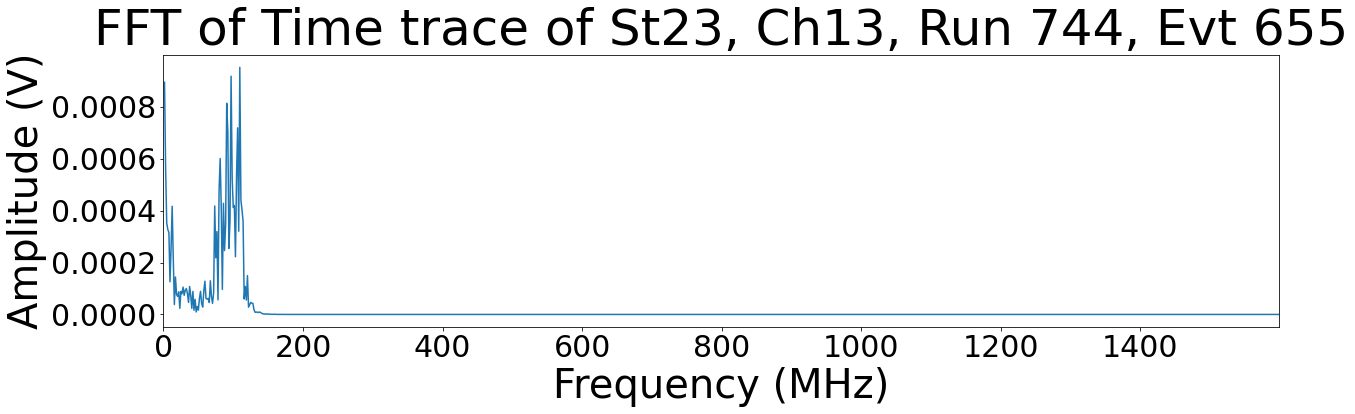

In [7]:
TimeTraceFFTLowpassFiltered(23,13,744,655,110*10**6)